In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
import re
from corpus_processing import PROCESSED_DATA_PATH, PROCESSED_DATA_PATH_PICKLE, DATA_PATH
import matplotlib.pyplot as plt

In [8]:
ONLY_WORDS_AND_DIGITS_REGEX = re.compile(r'[\w\dא-ת]+')
def get_only_words_and_digits(text: str):
    return ONLY_WORDS_AND_DIGITS_REGEX.findall(text)

def text_to_word_list(text: str):
    return get_only_words_and_digits(text)
    #return text.split()

def invert_words(words: list):
    return [w[::-1] for w in words]

In [9]:
def words_count(texts: pd.Series):
    texts_split = pd.Series((text_to_word_list(text) for text in texts))

    return texts_split.map(lambda x: len(x)).hist()

In [10]:
def most_common_words(texts: pd.Series, n: int, stopwords: list = None):
    if stopwords is None:
	    stopwords = []
    words_counter = Counter()
    for text in texts:
        for word in text_to_word_list(text):
            if word not in stopwords:
                words_counter[word] += 1
    sorted_word_count = sorted(words_counter.items(), key=lambda x:x[1], reverse=True)
    with open("word_count_all_text.txt", 'w', encoding='utf-8') as f:
        for item in sorted_word_count:
            f.write(item[0] + " : " + str(item[1]))
            f.write("\n")
    words, count = zip(*sorted_word_count[:n])
    words = invert_words(words)
    fig = plt.figure(figsize=(15,10))
    return plt.bar(words, count)


<BarContainer object of 20 artists>

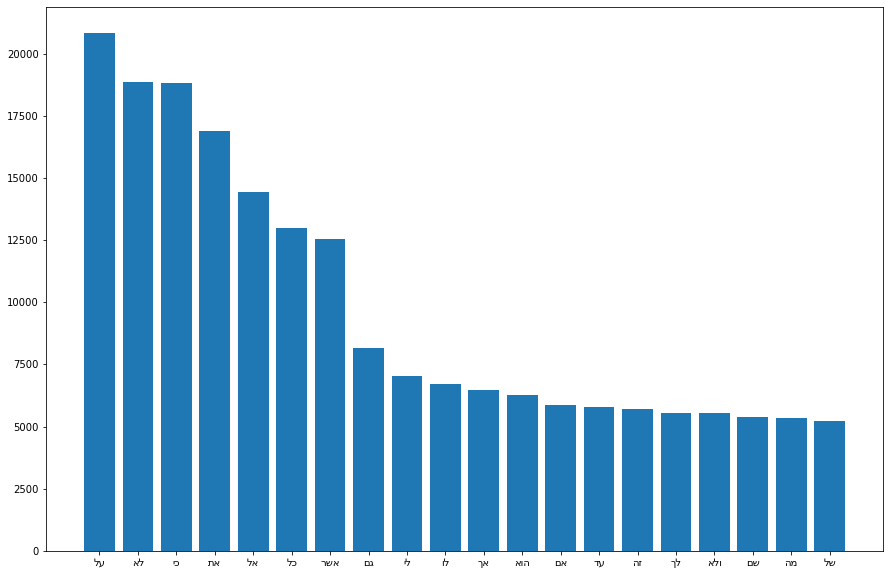

In [11]:
#df = pd.read_csv(PROCESSED_DATA_PATH)
df = pd.read_pickle(PROCESSED_DATA_PATH_PICKLE)

most_common_words(df.content, 20)

In [12]:
def plot_word_number_histogram(text: pd.Series):
    return text.map(lambda x: len(text_to_word_list(x))).hist(bins=50)

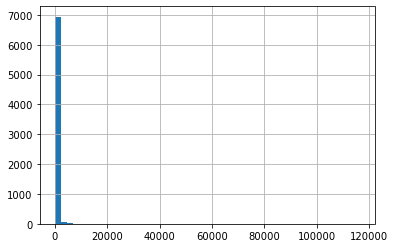

In [13]:
plot_word_number_histogram(df.content)
df['words_count'] = df.content.map(lambda x: len(text_to_word_list(x)))
df.to_csv("words_count.csv", columns=["ID","title","authors","genre","words_count"])

In [14]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
import pyLDAvis.gensim

def get_lda_objects(text, num_of_topics=6):

    def _preprocess_text(text):
        corpus=[]
        lem=WordNetLemmatizer()
        for news in text:
            words= text_to_word_list(news)

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    lda_model =  gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = num_of_topics,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)

    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [15]:
STOP_WORDS_FILE_PATH = DATA_PATH / Path("heb_stopwords.txt")
def get_stop_words() -> list:
    with open(STOP_WORDS_FILE_PATH, 'r') as file:
        result = [line.strip() for line in file]
    return result


C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
#lda_model, bow_corpus, dic = get_lda_objects(df.content)
#lda_model.show_topics()

C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
#plot_lda_vis(lda_model, bow_corpus, dic)

C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
from dateutil import parser

def get_year(year_str):
    try:
        if year_str and year_str is not np.nan:
            if '0000' in year_str:
                return 0
            return parser.parse(year_str).year
    except:
        return None

israel_cities = {"Tel Aviv", "Jaffa", "Jerusalem", "Haifa", "Nahalal", "Acre", "Ramat Gan", "Givat Hashlosha",
                 "Rishon LeZion", "Petah Tikva", "Zikhron Ya'akov", "Israel", "Mandatory Palestine"}
ancient_period = range(-2000, 500)
spain_period = range(500, 1400)
renaissance_period = range(1400, 1800)
nineteenth_century = range(1800, 1900)
twentieth_century = range(1900, 2000)
modern_times = range(2000, 2100)

def parse_authors(df : pd.DataFrame, cities : set):
    df["hebrew_speaker"] = df["Hebrew Speaker"].fillna(True).apply(lambda x: 1 if x else 0)
    df["p_birth_israel"] = df["p_birth"].apply(lambda x: 1 if x in cities else 0)
    df["p_death_israel"] = df["p_death"].apply(lambda x: 1 if x in cities else 0)
    birth_year = []
    death_year = []
    for index, row in df.iterrows():
        birth_year.append(get_year(row["d_birth"]))
        death_year.append(get_year(row["d_death"]))
        if birth_year[-1] is None or death_year[-1] is None:
            print(f"{row.name} don't have valid birth or death date.")
    df["b_year"] = birth_year
    df["d_year"] = death_year

    df["b_ancient"] = df["b_year"].apply(lambda x: 1 if x in ancient_period else 0)
    df["b_spain"] = df["b_year"].apply(lambda x: 1 if x in spain_period else 0)
    df["b_renaissance"] = df["b_year"].apply(lambda x: 1 if x in renaissance_period else 0)
    df["b_19ct"] = df["b_year"].apply(lambda x: 1 if x in nineteenth_century else 0)
    df["b_20ct"] = df["b_year"].apply(lambda x: 1 if x in twentieth_century else 0)
    df["b_modern"] = df["b_year"].apply(lambda x: 1 if x in modern_times else 0)

    df["d_ancient"] = df["d_year"].apply(lambda x: 1 if x in ancient_period else 0)
    df["d_spain"] = df["d_year"].apply(lambda x: 1 if x in spain_period else 0)
    df["d_renaissance"] = df["d_year"].apply(lambda x: 1 if x in renaissance_period else 0)
    df["d_19ct"] = df["d_year"].apply(lambda x: 1 if x in nineteenth_century else 0)
    df["d_20ct"] = df["d_year"].apply(lambda x: 1 if x in twentieth_century else 0)
    df["d_modern"] = df["d_year"].apply(lambda x: 1 if x in modern_times else 0)
    return df

C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
from corpus_processing import DATA_PATH
authors_stats_df_path = DATA_PATH / Path("authors_processed/authors_stats.pkl.gz")

authors_data_frame = pd.read_pickle(authors_stats_df_path).drop(columns=["songs_count", "sentence_count", "words_count", "words_total", "words_mean", "sentence_total", "sentence_mean"])
data = parse_authors(authors_data_frame,israel_cities)
authors_data_frame.head(10)

C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


אלמוני/ת don't have valid birth or death date.
יוסף בן שמואל צרפתי don't have valid birth or death date.
יצחק בעל “עזרת נשים” don't have valid birth or death date.
חיא don't have valid birth or death date.
אינוקנטי אננסקי don't have valid birth or death date.


,id,sex,p_birth,p_death,d_birth,d_death,Hebrew Speaker,hebrew_speaker,p_birth_israel,p_death_israel,...,b_renaissance,b_19ct,b_20ct,b_modern,d_ancient,d_spain,d_renaissance,d_19ct,d_20ct,d_modern
הומרוס,195,male,Smyrna$$$$$$$$1 reference$$$$$$stated in$$$$$F...,Ios$$$$$$$$1 reference$$$$$$imported from Wiki...,0000-08-05,0000-08-05,False,0,0,0,...,0,0,0,0,1,0,0,0,0,0
שאול טשרניחובסקי,16,male,Mykhailivka,Jerusalem,1875-08-20,1943-10-14,NaN,1,0,1,...,0,1,0,0,0,0,0,0,1,0
עמנואל הרומי,107,male,Rome,Fermo,1260-01-01,1328-01-01,NaN,1,0,0,...,0,0,0,0,0,1,0,0,0,0
שלמה אבן גבירול,40,male,M?laga,Valencia,1021-01-01,11/18/1057,NaN,1,0,0,...,0,0,0,0,0,1,0,0,0,0
אברהם אבן עזרא,46,male,Tudela,Tudela,1089-01-01,1167-10-15,NaN,1,0,0,...,0,0,0,0,0,1,0,0,0,0
יהודה ליב גורדון,2,male,Vilnius,Saint Petersburg,1830-12-07,1892-09-16,NaN,1,0,0,...,0,1,0,0,0,0,0,1,0,0
יהודה הלוי,26,male,Tudela,Jerusalem,1079-01-01,1141-01-01,NaN,1,0,1,...,0,0,0,0,0,1,0,0,0,0
ג'ון מילטון,397,male,Cheapside$$$$$$$$located in the administrative...,London,1608-01-01,1674-01-01,False,0,0,0,...,1,0,0,0,0,0,1,0,0,0
חיים נחמן ביאליק,6,male,Hrada,Vienna,1873-12-07,1934-07-04,NaN,1,0,0,...,0,1,0,0,0,0,0,0,1,0
שמואל הנגיד,32,male,C?rdoba,Granada,0933-06-09,1055-06-09,NaN,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [26]:
# combine the authors data with songs data

combined_df = df.merge(authors_data_frame, how="left", right_index=True, left_on="authors")
combined_df.head(10)

C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,ID,path,title,authors,translators,original_language,genre,source_edition,content,...,b_renaissance,b_19ct,b_20ct,b_modern,d_ancient,d_spain,d_renaissance,d_19ct,d_20ct,d_modern
0,2,16,/p46/m16,לידידי הרב החכם רב-הפעלים,יהודה ליב גורדון,NaN,NaN,שירה,NaN,\t \t \t לידידי הרב החכם רב-הפעלים מ...,...,0,1,0,0,0,0,0,1,0,0
1,5,19,/p141/m19,הֲלָךְ נֶפֶשׁ,רחל בלובשטיין,NaN,NaN,שירה,NaN,\t \t \t לא. ד. גורדון היום הלך ו...,...,0,1,0,0,0,0,0,0,1,0
2,6,20,/p89/m20,אל הציפור,חיים נחמן ביאליק,NaN,NaN,שירה,NaN,"\t \t \t שלום רב שובך, צפרה נחמדת, מאר...",...,0,1,0,0,0,0,0,0,1,0
3,7,21,/p89/m21,מִשּׁוּט בַּמֶּרְחַקִּים,חיים נחמן ביאליק,NaN,NaN,שירה,NaN,"\t \t \t משוט במרחקים, ממקומות נדדתי, ...",...,0,1,0,0,0,0,0,0,1,0
4,8,22,/p67/m22,בורגני וחלוץ עני: זמר לעם,קדיש יהודה סילמן,NaN,NaN,שירה,NaN,\t \t \t לשיר בנגון אקדמות אלף – אבטיח...,...,0,1,0,0,0,0,0,0,1,0
5,9,23,/p89/m23,הִרְהוּרֵי לָיְלָה,חיים נחמן ביאליק,NaN,NaN,שירה,NaN,\t \t \t ידעתי כי בכיי –בכי כוס בין חרב...,...,0,1,0,0,0,0,0,0,1,0
6,10,24,/p89/m24,על אילת השחר,חיים נחמן ביאליק,NaN,NaN,שירה,NaN,\t \t \t מאורה על־פי נוסח ספרד נחש...,...,0,1,0,0,0,0,0,0,1,0
7,11,25,/p89/m25,בִּתְשׁוּבָתִי,חיים נחמן ביאליק,NaN,NaN,שירה,NaN,"\t \t \t שוב לפני: זקן בלה, פנים צמקים...",...,0,1,0,0,0,0,0,0,1,0
8,14,31,/p14/m31,[שד הרמון],אברהם שטרן,NaN,NaN,שירה,NaN,\t \t \t שד הרמון הכף עפקת. הגו נצמד...,...,0,0,1,0,0,0,0,0,1,0
9,15,32,/p170/m32,[כִּסְעִיף הֲדַס תִּטֶּה צְבִיָּה],משה אבן עזרא,NaN,NaN,שירה,NaN,\t \t \t כסעיף הדס תטה צביה עת / תרקד ו...,...,0,0,0,0,0,1,0,0,0,0


## test data on with twentieth_century songs

In [27]:
from sklearn.model_selection import train_test_split

X = combined_df.content
y = combined_df.b_20ct

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(f"Test set has {len(X_train)} samples, and test have {len(X_test)}")
print(f"In train set there {y_train.sum()} songs from 20ct\n"
      f"In test set there {y_test.sum()} songs from 20ct")

Test set has 6319 samples, and test have 703
In train set there 327 songs from 20ct
In test set there 30 songs from 20ct


C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## run the pipeline:

C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


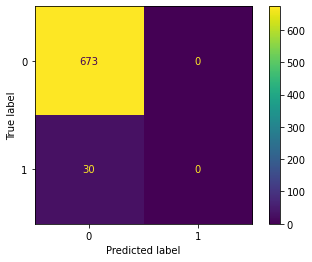

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

vectorizer=CountVectorizer(ngram_range=(1,2))
transformer=TfidfTransformer()
algo=LogisticRegression()

pipe = Pipeline([('vectorizer', vectorizer),
                 ('transformer', transformer),
                 #('feature_select', SelectKBest(chi2, k=20000)),
                 ('algo', algo)])

pipe.fit(X_train, y_train)
prediction = pipe.predict(X_test)
plot_confusion_matrix(pipe, X_test, y_test)
plt.show()